In [1]:
import os

os.chdir("../..")
import utils

In [2]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'subdiagnostic'
experiment_name = 'exp1.1'

data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

X_train_lead1 = X_train[:,:,0]
X_test_lead1 = X_test[:,:,0]
X_val_lead1 = X_val[:,:,0]

This experiment has 23 classes


## Baseline CNN

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.models import Sequential

In [7]:
clf = Sequential()

clf.add(Conv1D(filters=32, kernel_size=(5,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape=(1000, 12)))
clf.add(Conv1D(filters=64, kernel_size=(5,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
clf.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
clf.add(MaxPool1D(pool_size=(5,), strides=2, padding='same'))
clf.add(Dropout(0.5))
clf.add(Flatten())

clf.add(Dense(units=512, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
clf.add(Dense(units=1024, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
clf.add(Dense(units=23, activation='sigmoid'))

In [9]:
from keras.utils import plot_model
clf.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1000, 32)          1952      
                                                                 
 conv1d_5 (Conv1D)           (None, 1000, 64)          10304     
                                                                 
 conv1d_6 (Conv1D)           (None, 1000, 128)         41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                      

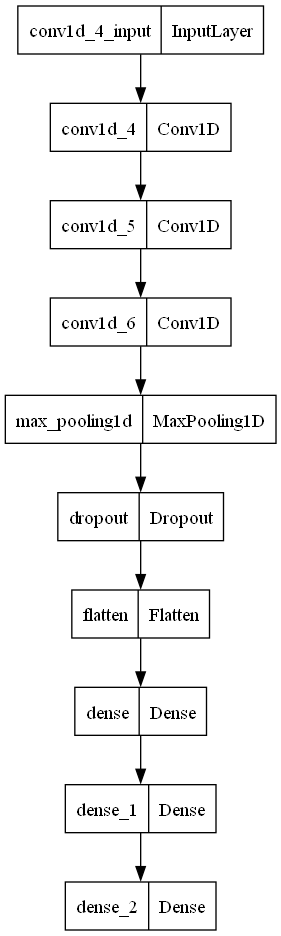

In [10]:
plot_model(clf)

In [11]:
clf.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(num_thresholds=200,
                                curve="ROC",
                                summation_method='interpolation',
                                name="AUC",
                                multi_label=True,
                                label_weights=None)])

In [13]:
clf.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)

Epoch 1/10
134/134 [==============================] - 173s 1s/step - loss: 8.3906 - accuracy: 0.8987 - recall: 0.1996 - AUC: 0.4995 - val_loss: 2.9633 - val_accuracy: 0.9390 - val_recall: 0.2728 - val_AUC: 0.5067
Epoch 2/10
134/134 [==============================] - 158s 1s/step - loss: 2.8951 - accuracy: 0.9053 - recall: 0.2006 - AUC: 0.5021 - val_loss: 1.6722 - val_accuracy: 0.9060 - val_recall: 0.1228 - val_AUC: 0.5067
Epoch 3/10
134/134 [==============================] - 140s 1s/step - loss: 1.6521 - accuracy: 0.9055 - recall: 0.2029 - AUC: 0.4990 - val_loss: 1.3865 - val_accuracy: 0.8994 - val_recall: 0.0454 - val_AUC: 0.5039
Epoch 4/10
134/134 [==============================] - 140s 1s/step - loss: 3.2066 - accuracy: 0.9005 - recall: 0.2044 - AUC: 0.5023 - val_loss: 2.1068 - val_accuracy: 0.9073 - val_recall: 0.1060 - val_AUC: 0.5133
Epoch 5/10
134/134 [==============================] - 150s 1s/step - loss: 2.5788 - accuracy: 0.8999 - recall: 0.1942 - AUC: 0.5007 - val_loss: 2.70

KeyboardInterrupt: 

In [18]:
from sklearn.metrics import roc_auc_score

roc_auc_score(clf.predict(X_test)[:,0].reshape(-1,1), y_test[:,0].reshape(-1,1))

68/68 [==============================] - 6s 83ms/step


ValueError: continuous format is not supported

In [17]:
y_test[:,0].reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])